# Libraries

In [73]:
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups #news group data set
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn import svm
# Question 4 Library
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Question 1

Plot a histogram of the number of training documents for each of the 20 categories to check if they are evenly distributed.

In [74]:
newsgroups_train = fetch_20newsgroups(subset='train')

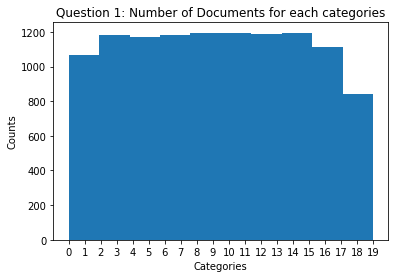

In [75]:
type(newsgroups_train.target)
news_target = newsgroups_train.target
plt.hist(news_target)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(list(range(20)))
plt.title('Question 1: Number of Documents for each categories')
plt.show()

# Question 2

Use the following specs to extract features from the textual data:
• Use the “english” stopwords of the CountVectorizer
• Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
• Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
• Use min_df=3
Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [76]:
np.random.seed(42);
random.seed(42); # do I set the random here
categories = ['comp.graphics', 
              'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 
              'comp.sys.mac.hardware', 
              'rec.autos', 
              'rec.motorcycles', 
              'rec.sport.baseball', 
              'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=None)
test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=None)

In [77]:
# Customize analyzer
analyzer = CountVectorizer().build_analyzer();
# Lemmatizer
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
def lemmatize_sent(list_word):
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag, in pos_tag(list_word)]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())
count_vect = CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)

### Training Part

In [78]:
tfidf_transformer = TfidfTransformer()
X_train_counts = count_vect.fit_transform(train_dataset.data)
X_train_tf_idf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tf_idf.shape

(4732, 16600)

### Testing Part

In [79]:
X_test_counts = count_vect.transform(test_dataset.data)
X_test_tf_idf = tfidf_transformer.transform(X_test_counts)
X_test_tf_idf.shape

(3150, 16600)

# Question 3

Reduce the dimensionality of the data using the methods above

• Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50; so each document is mapped to a 50-dimensional vector.

• Also reduce dimensionality through NMF (k = 50) and compare with LSI:
Which one is larger, the ∥X − WH∥ F 2 in NMF or the X − U k Σ k V T k F in LSI? Why is the case?

In [80]:
# NMF
## Train
model = NMF(n_components=50, init='random', random_state=0)
NMF_train_reduced = model.fit_transform(X_train_tf_idf)
## Test
NMF_test_reduced = model.transform(X_test_tf_idf)
print("NMF train shape: ", NMF_train_reduced.shape)
print("NMF test shape: ", NMF_test_reduced.shape)

NMF train shape:  (4732, 50)
NMF test shape:  (3150, 50)


In [81]:
H_train = model.components_
NMF_train_val = np.sum(np.array(X_train_tf_idf - NMF_train_reduced.dot(H_train))**2)
NMF_test_val = np.sum(np.array(X_test_tf_idf - NMF_test_reduced.dot(H_train))**2)

In [82]:
print("||X-WH||^2_F Train: ", NMF_train_val)
print("||X-WH||^2_F Test: ", NMF_test_val)

||X-WH||^2_F Train:  3940.5577667857324
||X-WH||^2_F Test:  2691.949309920702


In [83]:
# LSI
## Train
svd = TruncatedSVD(n_components=50, random_state=0)
LSI_train_reduced = svd.fit_transform(X_train_tf_idf)
## Test
LSI_test_reduced = svd.transform(X_test_tf_idf)
print("LSI train shape: ", LSI_train_reduced.shape)
print("LSI test shape: ", LSI_test_reduced.shape)

LSI train shape:  (4732, 50)
LSI test shape:  (3150, 50)


In [84]:
H = svd.components_
## Train
LSI_train_val = np.sum(np.array(X_train_tf_idf - LSI_train_reduced.dot(H))**2)
## Test
LSI_test_val = np.sum(np.array(X_test_tf_idf - LSI_test_reduced.dot(H))**2)

In [85]:
print("||X - USigmaV^T||^2_F Train", LSI_train_val)
print("||X - USigmaV^T||^2_F Test", LSI_test_val)

||X - USigmaV^T||^2_F Train 3895.601668902094
||X - USigmaV^T||^2_F Test 2676.5911826488655


# Question 4

In [137]:
def mergeToBinary(multiClassArray):
    res = np.copy(multiClassArray)
    for i in range(len(multiClassArray)):
        if multiClassArray[i] <= 3:
            res[i] = 0
        else:
            res[i] = 1
    return res

In [138]:
train_labels = mergeToBinary(train_dataset.target)
test_labels = mergeToBinary(test_dataset.target)

In [139]:
%matplotlib inline
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
#     return pipe

def confusionMatrixAndMetrics(ground_truth, predicts):
    conf_matrix = confusion_matrix(ground_truth, predicts)
    preci = precision_score(ground_truth, predicts)
    recall = recall_score(ground_truth, predicts)
    F1 = 2 / (1/recall + 1/preci)
    print("precision: ", preci)
    print("recall: ", recall)
    print("F1 score: ", F1)
    print ("confusion matrix: \n", conf_matrix)

precision:  0.9675202998126171
recall:  0.9742138364779874
F1 score:  0.9708555311814479
confusion matrix: 
 [[1508   52]
 [  41 1549]]


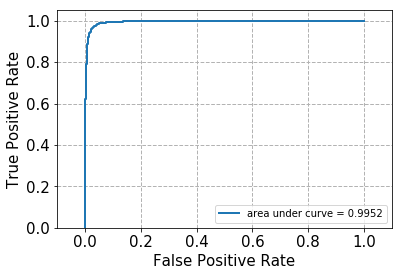

In [140]:
hard_model = LinearSVC(loss='hinge', C=1000)
fit_predict_and_plot_roc(hard_model, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = hard_model.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)

precision:  0.5050825921219823
recall:  1.0
F1 score:  0.671169269734065
confusion matrix: 
 [[   2 1558]
 [   0 1590]]


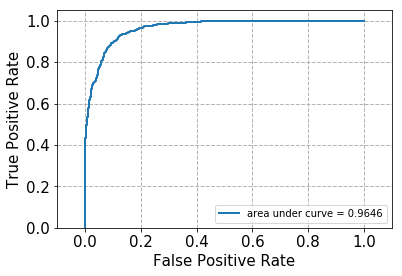

In [141]:
soft_model = LinearSVC(loss='hinge', C=0.0001)
fit_predict_and_plot_roc(soft_model, LSI_train_reduced , train_labels, LSI_test_reduced, test_labels)
predicts = soft_model.fit(LSI_train_reduced, train_labels).predict(LSI_test_reduced)
confusionMatrixAndMetrics(test_labels, predicts)